In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import pickle

tf.get_logger().setLevel('ERROR')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

def load_images_from_directory(directory):
    data, labels = [], []
    class_names = sorted(os.listdir(directory))
    for label, class_name in enumerate(class_names):
        class_path = os.path.join(directory, class_name)
        for file in os.listdir(class_path):
            img_path = os.path.join(class_path, file)
            img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
            img = tf.keras.utils.img_to_array(img)
            data.append(img)
            labels.append(label)
    return np.array(data), np.array(labels), class_names

data_dir = "/content/drive/MyDrive/Colab Notebooks/Science Fair/Final_AugmentedDataset"
data, labels, class_names = load_images_from_directory(data_dir)

indices = np.arange(len(data))
np.random.shuffle(indices)
data, labels = data[indices], labels[indices]

split_idx = int(0.8 * len(data))
train_images, val_images = data[:split_idx], data[split_idx:]
train_labels, val_labels = labels[:split_idx], labels[split_idx:]

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=len(class_names))
val_labels = tf.keras.utils.to_categorical(val_labels, num_classes=len(class_names))

def preprocess_data(image, label, augment=False):
    image = tf.cast(image, tf.float32) / 255.0
    if augment:
        image = tf.image.random_flip_left_right(image)
        image = random_rotation(image)
    return image, label

random_rotation = tf.keras.layers.RandomRotation(factor=0.1)

def create_dataset(images, labels, batch_size, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.shuffle(buffer_size=len(images))
    dataset = dataset.map(lambda x, y: preprocess_data(x, y, augment=augment),
                          num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

batch_size = 32
train_dataset = create_dataset(train_images, train_labels, batch_size, augment=True)
val_dataset = create_dataset(val_images, val_labels, batch_size)

class_counts = np.sum(train_labels, axis=0)
class_weights = {i: len(train_labels) / (len(class_names) * count) if count > 0 else 1.0
                 for i, count in enumerate(class_counts)}

print(f"Class Weights: {class_weights}")

Class Weights: {0: 1.044776119402985, 1: 1.0163339382940109, 2: 0.9671848013816926, 3: 0.975609756097561}


In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True

for layer in base_model.layers[:-30]:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 1,690,884 (6.45 MB)

 Non-trainable params: 731,584 (2.79 MB)

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - accuracy: 0.3697 - loss: 1.4164 - val_accuracy: 0.5429 - val_loss: 1.0756 - learning_rate: 1.0000e-04
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.6801 - loss: 0.8159 - val_accuracy: 0.6661 - val_loss: 0.8342 - learning_rate: 1.0000e-04
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.7532 - loss: 0.6680 - val_accuracy: 0.7357 - val_loss: 0.6960 - learning_rate: 1.0000e-04
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - accuracy: 0.8061 - loss: 0.5131 - val_accuracy: 0.7089 - val_loss: 0.7007 - learning_rate: 1.0000e-04
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - accuracy: 0.8461 - loss: 0.4357 - val_accuracy: 0.6768 - val_loss: 0.8152 - learning_rate: 1.0000e-04
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8613 - loss: 0.3416
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
70/70 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.8614 - loss:

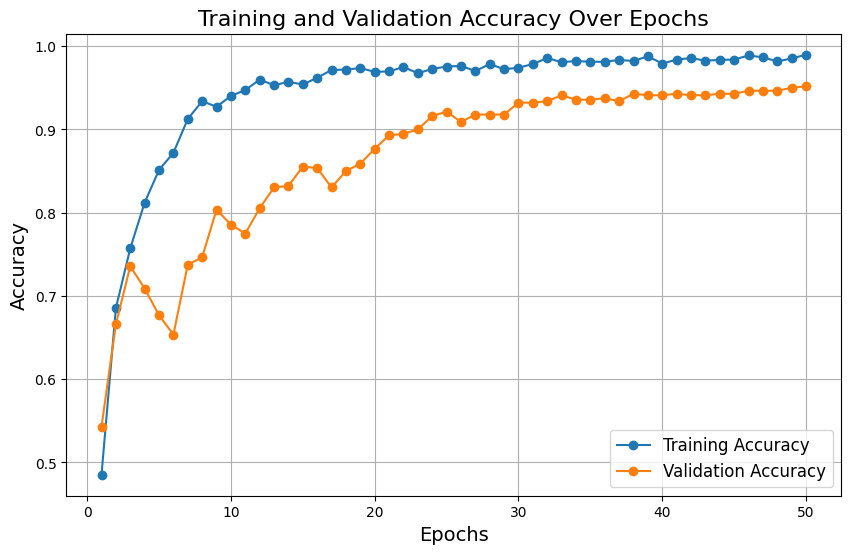

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

callbacks_list = [reduce_lr]

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    class_weight=class_weights,
    verbose=1,
    callbacks=callbacks_list
)

results = {
    "accuracy": history.history['accuracy'],
    "val_accuracy": history.history['val_accuracy'],
    "loss": history.history['loss'],
    "val_loss": history.history['val_loss']
}

pickle_filename = "training_results_fixed.pkl"
with open(pickle_filename, 'wb') as file:
    pickle.dump(results, file)

print(f"Training results saved to {pickle_filename}")

epochs = range(1, len(history.history['accuracy']) + 1)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, label='Training Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
model.save('/content/drive/MyDrive/Colab Notebooks/Science Fair/saved_model/finalmodel.hdf5')